In [1]:
import os
from pathlib import Path
root = Path('/Users/user/Coding/EV-D68-3C-protease/')
os.chdir(root)

In [2]:
import pandas as pd
import requests
from typing import List, Union
from rdkit import Chem
from rdkit.Chem import AllChem

options = []

class RowGetter:
    """
    Given a pandas table with a column w/ a molecule,
    find the _first_ match of a given molecule.

    This is not inchi based, which may be silly
    Furthermore, what if a molecules is from different libraries?

    .. codeblock::python
        library_collection = pd.read_csv('../XChem-targets/combined_libraries.csv', index_col=0)
        PandasTools.AddMoleculeColumnToFrame(library_collection, 'SMILES', 'molecule', True)
        RowGetter(library_collection, 'molecule').get_matching_hits(mols)
    """
    def __init__(self, df: pd.DataFrame, mol_col: str):
        self.df = df
        self.mol_col = mol_col
        self.df['disordered'] = self.df[self.mol_col].apply(self.disorder)

    def disorder(self, mol: Chem.Mol) -> Chem.Mol:
        """
        As in, lacks bond order
        """
        disorded = Chem.Mol(mol)
        for bond in disorded.GetBonds():
            bond.SetBondType(Chem.BondType.SINGLE)
        return disorded


    def __call__(self, hit: Chem.Mol) -> Union[None, pd.Series]:
        hit = AllChem.RemoveAllHs(hit)
        m = (self.df[self.mol_col].apply(lambda m: hit.GetNumHeavyAtoms() == m.GetNumHeavyAtoms())) & (self.df[self.mol_col] >= hit)
        if sum(m) == 0:
            m = (self.df[self.mol_col].apply(lambda m: hit.GetNumHeavyAtoms() == m.GetNumHeavyAtoms())) & (self.df.disordered >= hit)
        if sum(m) == 0:
            return None
        elif sum(m) == 1:
            return self.df.loc[m].reset_index().iloc[0]
        else:
            matches = self.df[m].reset_index()
            return pd.Series(dict(Id='Ambigous:' + '|'.join(set(matches.Id.to_list())),
                        SMILES=matches.iloc[0].SMILES,
                        molecule=matches.iloc[0].molecule,
                        library='Ambigous:' + '|'.join(set(matches.library.to_list())),
                        Name=matches.iloc[0].Name,
                        ))

    def get_matching_hits(self, hits: List[Chem.Mol]) -> pd.DataFrame:
        rows = []
        for hit in hits:
            row = self(hit)
            if row is None:
                rows.append(pd.Series({'3D_molecule': hit, 'in_library': False, 'query': hit, 'library': 'Unknown'}))
            else:
                row['query'] = hit
                row['3D_molecule'] = hit
                row['in_library'] = True
                rows.append(row)
        return pd.DataFrame(rows)

    @classmethod
    def smiles_to_iupac(cls, smiles: str, raise_error:bool=True) -> str:
        """
        Given a SMILES, get the IUPAC name from NIH Cactus server
        """
        rep = "iupac_name"
        CACTUS = "https://cactus.nci.nih.gov/chemical/structure/{0}/{1}"
        url = CACTUS.format(smiles, rep)
        response = requests.get(url)
        if response.ok:
            return response.text
        elif raise_error:
            response.raise_for_status()
        else:
            return ''

In [3]:
with Chem.SDMolSupplier('hits.sdf') as sds:
    hits = list(sds)

In [4]:
from rdkit.Chem import PandasTools

library_collection = pd.read_csv('02_hit-prep/combined_libraries.csv', index_col=0)
PandasTools.AddMoleculeColumnToFrame(library_collection, 'SMILES', 'molecule', True)
library_collection['_lib_rank'] = library_collection.library.map(dict(DSiPoised=0, FragLite=1, Euopen=2, PepLite=3, CovHetFrags=4, SpotXplorer=5, York3D=6, Leed3D=7, Cambridge3D=8))
library_collection.sort_values(by='_lib_rank', inplace=True)
library_collection['SMILES'] = library_collection.SMILES.apply(lambda smiles: sorted(smiles.split('.'), key=len)[-1])

In [ ]:
matches: pd.DataFrame = RowGetter(library_collection, 'molecule').get_matching_hits(hits).reset_index(drop=True)
matches['query'] = hits

In [127]:
matches.library.value_counts()

library
DSiPoised                    51
Unknown                      20
Ambigous:Leed3D|DSiPoised    12
SpotXplorer                   8
Euopen                        4
CovHetFrags                   4
York3D                        3
PepLite                       1
FragLite                      1
Name: count, dtype: int64

In [ ]:
## JUNK

In [ ]:
# missing bond order

def fix(row):
    if not row.in_library:
        return None
    mol = AllChem.AssignBondOrdersFromTemplate(Chem.MolFromSmiles(row.SMILES), row['3D_molecule'])
    name = str(row['Name']) if isinstance(row['Name'], str) and '<!DOCTYPE' not in str(row['Name']) else 'unknown'
    mol.SetProp('name', name)
    for key in ('Id','SMILES', 'library'):
        mol.SetProp(key, row[key])
    return mol

mols = matches.apply(fix, axis=1).to_list()

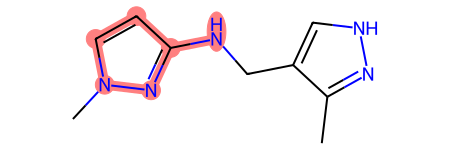

In [70]:
options[0][1].molecule[4]

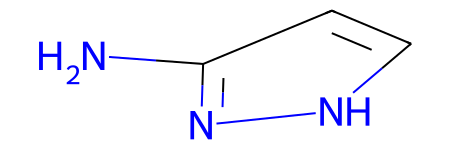

In [38]:
matches.iloc[5]['3D_molecule']

In [25]:
import clipboard

clipboard.copy(' '.join(set(library_collection.library.to_list())))

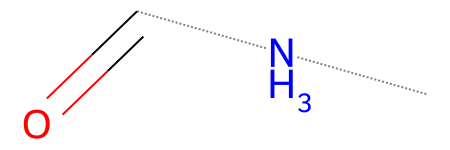

In [7]:
Chem.MolFromSmiles('C~N~C(=O)')

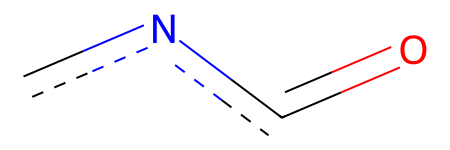

In [11]:
Chem.MolFromSmarts('C:N:C(=O)')

In [16]:
library_collection.loc[library_collection.molecule >= Chem.MolFromSmarts('cnc(=O)')].molecule

ReadProperties: value line ignored
ReadProperties: buffer = 'V    1 c'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    2 n'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    3 c'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    4 O'


508    <rdkit.Chem.rdchem.Mol object at 0x165c786d0>
824    <rdkit.Chem.rdchem.Mol object at 0x165c91d90>
816    <rdkit.Chem.rdchem.Mol object at 0x165c91690>
669    <rdkit.Chem.rdchem.Mol object at 0x165c814d0>
145    <rdkit.Chem.rdchem.Mol object at 0x165c54660>
15     <rdkit.Chem.rdchem.Mol object at 0x165c45380>
329    <rdkit.Chem.rdchem.Mol object at 0x165c62880>
289    <rdkit.Chem.rdchem.Mol object at 0x165c60580>
366    <rdkit.Chem.rdchem.Mol object at 0x165c68970>
209    <rdkit.Chem.rdchem.Mol object at 0x165c57e60>
6      <rdkit.Chem.rdchem.Mol object at 0x165f26260>
5      <rdkit.Chem.rdchem.Mol object at 0x165f26180>
27     <rdkit.Chem.rdchem.Mol object at 0x165f274c0>
28     <rdkit.Chem.rdchem.Mol object at 0x165f275a0>
29     <rdkit.Chem.rdchem.Mol object at 0x165f27680>
591    <rdkit.Chem.rdchem.Mol object at 0x165ccf7d0>
705    <rdkit.Chem.rdchem.Mol object at 0x165cd5cb0>
658    <rdkit.Chem.rdchem.Mol object at 0x165cd3300>
664    <rdkit.Chem.rdchem.Mol object at 0x165c

In [1]:
hits

NameError: name 'hits' is not defined

In [ ]:
good = ['x0147_0A_1',
 'x0771_1A_1',
 'x0789_0A_1',
 'x0980_0B_1',
 'x1083_0A_1',
 'x1247_0A_1',
 'x1305_0B_1',
 'x1498_1B_1',
 'x1594_0A_1',
 'x1604_0A_1']